# 使用geatpy优化B_GRU定位模型参数

In [1]:
import math
import copy
import numpy as np
import pandas as pd
import geatpy as ea
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Activation, SimpleRNN, LSTM, GRU, Add, Dropout
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

## 读取数据

In [2]:
# 加载训练数据
def load_data(path):
    df = pd.read_csv(path)
    dv = df.values
    X = dv[:, 1:-2]
    Y = dv[:, -2:]
    return X[:, :, np.newaxis], Y

In [3]:
X, y = load_data('./dataset/location_data.csv')
print(X.shape)

(2000, 100, 1)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)  # 训练测试划分
# 针对b_gru处理数据
X_train_2 = copy.deepcopy(X_train)
X_test_2 = copy.deepcopy(X_test)
for i in range(len(X_train_2)):
    for j in range(len(X_train_2[i])-1, 0, -1):
        X_train_2[i][j] = X_train_2[i][j] - X_train_2[i][j-1]
for i in range(len(X_test_2)):
    for j in range(len(X_test_2[i]) - 1, 0, -1):
        X_test_2[i][j] = X_test_2[i][j] - X_test_2[i][j-1]

## 定义B_GRU模型

In [5]:
def RFID_B_GRU():
    m3_input_layer_1 = Input(shape=(100, 1))
    m3_input_layer_2 = Input(shape=(100, 1))
    m3_gru_layer_1 = GRU(100,
                          # kernel_initializer=initializers.RandomNormal(stddev=0.001),
                          # recurrent_initializer=initializers.Identity(gain=1.0),
                          # kernel_regularizer=regularizers.l1(0.01),
                          # activity_regularizer=regularizers.l2(0.01),
                          # recurrent_dropout=0.1,
                          batch_input_shape=(None, 100, 1))(m3_input_layer_1)
                         
    m3_gru_layer_2 = GRU(100,
                          # kernel_initializer=initializers.RandomNormal(stddev=0.001),
                          # recurrent_initializer=initializers.Identity(gain=1.0),
                          # kernel_regularizer=regularizers.l1(0.01),
                          # activity_regularizer=regularizers.l2(0.01),
                          # recurrent_dropout=0.1,
                          batch_input_shape=(None, 100, 1))(m3_input_layer_2)

    m3_merged_layer = Concatenate()([m3_gru_layer_1, m3_gru_layer_2])
    # m3_merged_layer = Add()([m3_lstm_layer_1, m3_lstm_layer_2])
    # m4_lstm_layer = GRU(110, batch_input_shape=(None, 110, 2))(m3_merged_layer)
    # m3_final_layer0 = Dense(20)(m3_merged_layer)
    # dropout_layer = Dropout(0.2)(m3_merged_layer)
    # m3_dense_layer = Dense(2)(m3_merged_layer)
    m3_final_layer = Dense(2)(m3_merged_layer)
    model = Model(inputs=[m3_input_layer_1, m3_input_layer_2], outputs=m3_final_layer, name="Model")
    # plot_model(model, 'model.png', show_shapes=True)
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    # model.summary()
    return model

## 训练模型查看测试效果

In [6]:
%%time
model = RFID_B_GRU()
model.fit([X_train, X_train_2], y_train, epochs=10, batch_size=100)
loss = model.evaluate([X_test, X_test_2], y_test, batch_size=10) # 输出损失和MAE
print('损失与精度：', loss)
model.save('./models/B_GRU_2021.h5')

pxy = model.predict([X_test, X_test_2])
print(pxy[:10])
print(y_test[:10])
MAE = mean_absolute_error(y_test, pxy)
MSE = mean_squared_error(y_test, pxy)
r2 = r2_score(y_test, pxy)
ev = explained_variance_score(y_test, pxy)
print('MAE指标:', MAE)
print('MSE指标:', MSE)
print('RMSE指标:', math.sqrt(MSE))
print('r2指标:', r2)
print('ev指标:', ev)


2022-01-03 17:36:59.373120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 17:36:59.689917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-03 17:36:59.717040: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/10
16/16 [==============================] - 2s 34ms/step - loss: 26.4779 - mae: 4.3113
Epoch 2/10
16/16 [==============================] - 1s 35ms/step - loss: 8.0366 - mae: 2.4058
Epoch 3/10
16/16 [==============================] - 1s 35ms/step - loss: 6.1808 - mae: 2.1283
Epoch 4/10
16/16 [==============================] - 1s 35ms/step - loss: 5.0152 - mae: 1.8585
Epoch 5/10
16/16 [==============================] - 1s 35ms/step - loss: 4.1015 - mae: 1.5773
Epoch 6/10
16/16 [==============================] - 1s 35ms/step - loss: 3.5910 - mae: 1.4519
Epoch 7/10
16/16 [==============================] - 1s 35ms/step - loss: 3.2278 - mae: 1.3661
Epoch 8/10
16/16 [==============================] - 1s 37ms/step - loss: 2.7155 - mae: 1.2556
Epoch 9/10
16/16 [==============================] - 1s 35ms/step - loss: 2.1478 - mae: 1.1151
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 1.4865 - mae: 0.9335
损失与精度： [1.4865140914916992, 0.9334833025932312]
[[4.001015 

## 使用进化算法调参

 ### 自定义问题类

In [7]:
class RFIDBGRU(ea.Problem):
    def __init__(self, X_train, X_train_2, X_test, X_test_2, y_train, y_test):
        name = 'RFIDBGRU'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [10, 50] # 决策变量下界
        ub = [500, 500] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.X_train = X_train
        self.X_train_2 = X_train_2
        self.X_test = X_test
        self.X_test_2 = X_test_2
        self.y_train = y_train
        self.y_test = y_test
        
        
    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs = int(Vars[i, 0])
            batch_size = int(Vars[i, 1])
            model = RFID_B_GRU()
            model.fit([self.X_train, self.X_train_2], self.y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            pxy = model.predict([self.X_test, self.X_test_2])
            pop.ObjV[i] = r2_score(self.y_test, pxy) # 最小化MSE作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算
        
        
    # 代入优化后的参数对测试集进行检验，计算指标
    def test(self, epochs, batch_size):
        X02, y02 = load_data('./dataset/location_data02.csv')
        X02_2 = copy.deepcopy(X02)
        for i in range(len(X02_2)):
            for j in range(len(X02_2[i])-1, 0, -1):
                X02_2[i][j] = X02_2[i][j] - X02_2[i][j-1]
                
        model = RFID_B_GRU()
        model.fit([self.X_train, self.X_train_2], self.y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        model.save('./models/B_GRU_2021.h5')
        pxy = model.predict([X02, X02_2])
        MAE = mean_absolute_error(y02, pxy)
        MSE = mean_squared_error(y02, pxy)
        r2 = r2_score(y02, pxy)
        ev = explained_variance_score(y02, pxy)
        print('MAE指标:', MAE)
        print('MSE指标:', MSE)
        print('RMSE指标:', math.sqrt(MSE))
        print('r2指标:', r2)
        print('ev指标:', ev)
        

### 编写执行代码

gen|  eval  |    f_opt    |    f_max    |    f_avg    |    f_min    |    f_std    
----------------------------------------------------------------------------------
 0 |   10   | 9.78270E-01 | 9.78270E-01 | 9.51574E-01 | 7.25523E-01 | 7.53544E-02 
 1 |   20   | 9.78466E-01 | 9.78466E-01 | 9.77135E-01 | 9.75356E-01 | 8.26186E-04 
 2 |   30   | 9.78466E-01 | 9.78466E-01 | 9.77247E-01 | 9.75751E-01 | 7.38678E-04 
 3 |   40   | 9.78466E-01 | 9.78466E-01 | 9.77426E-01 | 9.76204E-01 | 6.39308E-04 
 4 |   50   | 9.78466E-01 | 9.78466E-01 | 9.77903E-01 | 9.77233E-01 | 3.98233E-04 
 5 |   60   | 9.78466E-01 | 9.78466E-01 | 9.77905E-01 | 9.77233E-01 | 3.96944E-04 
 6 |   70   | 9.78466E-01 | 9.78466E-01 | 9.77926E-01 | 9.77378E-01 | 3.73814E-04 
 7 |   80   | 9.78466E-01 | 9.78466E-01 | 9.77926E-01 | 9.77378E-01 | 3.73814E-04 
 8 |   90   | 9.78466E-01 | 9.78466E-01 | 9.77928E-01 | 9.77378E-01 | 3.75479E-04 
 9 |  100   | 9.78466E-01 | 9.78466E-01 | 9.77932E-01 | 9.77378E-01 | 3.71889E-04 
 10|

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


 12|  130   | 9.78801E-01 | 9.78801E-01 | 9.78141E-01 | 9.77499E-01 | 4.24733E-04 


/home/tjt/anaconda3/envs/tf2-frank/lib/python3.7/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 31181 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/tjt/anaconda3/envs/tf2-frank/lib/python3.7/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 32676 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/tjt/anaconda3/envs/tf2-frank/lib/python3.7/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/tjt/anaconda3/envs/tf2-frank/lib/python3.7/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 20307 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/tjt/anaconda3/envs/tf2-frank/lib/python3.7/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 24179 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/tjt/anaconda3/envs/tf2-frank/lib/p

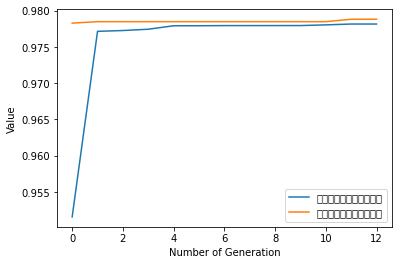

种群信息导出完毕。
用时：21070.943877 秒
评价次数：130 次
最优的目标函数值为：0.9788010181495856
最优的控制变量值为：
436.8772494920995
219.38439018267673
MAE指标: 0.26058854961395267
MSE指标: 0.11675852761181657
RMSE指标: 0.3416994697271516
r2指标: 0.9857048121084138
ev指标: 0.9881319972495695


In [8]:
"""===============================实例化问题对象==========================="""

problem = RFIDBGRU(X_train, X_train_2, X_test, X_test_2, y_train, y_test) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 30 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')
    
"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), batch_size= int(BestIndi.Phen[0][1]))
